#Material did√°tico - Sensoriamento Remoto com Google Earth Engine - Obtendo dados
Objetivo: Recupera√ß√£o de imagem, processamento b√°sico de valores, exporta√ß√£o de arquivo para uso em programas SIG.

Editor: Luizemara Szameitat (contato@lszameitat.com)

>Luizemara Szameitat √© bolsista CAPES - P√≥s-Doutorado Estrat√©gico 2022-2024.
O presente trabalho foi realizado com apoio da Coordena√ß√£o de Aperfei√ßoamento de Pessoal de N√≠vel Superior - Brasil (CAPES) - C√≥digo de Financiamento 001.

## 1. Preparar o ambiente

In [1]:
!pip install geemap earthengine-api ipyleaflet -q

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 6.3 MB/s eta 0:00:00


√â necess√°rio que o usu√°rio tenha criado um projeto no Google Cloud Platform no GEE. No painel administrativo do projeto, est√£o as informa√ß√µes do projeto. Copie o ID do projeto para usar aqui. Coloque voc√™ como propriet√°rio e como editor do projeto no painel IAM.

Abaixo, h√° duas formas de autenticar e iniciar. Vou deixar a primeira ativa, que usa uam vari√°vel ambiente secreta, inserida no Colab do usu√°rio (√© um m√©todo mais seguro). Mas a outra forma est√° abaixo, e precisa que o ID do projeto seja inserido no c√≥digo diretamente.

In [2]:
import os
import geemap
import ee

# GOOGLE COLAB - Adicionar chave secreta do projeto do Google Engine
from google.colab import userdata
chave_do_projeto = userdata.get('EE_PROJECT_ID')
# Autentica√ß√£o no Google Cloud
from google.colab import auth
auth.authenticate_user()
# Autentica√ß√£o no Earth Engine
ee.Authenticate()
# Inicializer o Earth Engine com o ID
ee.Initialize(project = chave_do_projeto )

'''
import os
from google.colab import userdata
import geemap
import ee


# Google Cloud project ID
project_id = '---INSIRA-SUA-CHAVE-AQUI---'
# Set the EE_PROJECT_ID environment variable
os.environ['EE_PROJECT_ID'] = project_id
# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()
# Authenticate with Earth Engine
ee.Authenticate()
# Initialize Earth Engine with the project ID
ee.Initialize(project=project_id)
'''

"\nimport os\nfrom google.colab import userdata\nimport geemap\nimport ee\n\n\n# Google Cloud project ID\nproject_id = '---INSIRA-SUA-CHAVE-AQUI---'\n# Set the EE_PROJECT_ID environment variable\nos.environ['EE_PROJECT_ID'] = project_id\n# Authenticate with Google Cloud\nfrom google.colab import auth\nauth.authenticate_user()\n# Authenticate with Earth Engine\nee.Authenticate()\n# Initialize Earth Engine with the project ID\nee.Initialize(project=project_id)\n"

In [3]:
# Teste para ver se est√° funcionando
x = geemap.Map()
x

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr‚Ä¶

##2 . Escolher um ponto de interesse
Busque as coordenadas do seu alvo de estudo.

In [4]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
from ipywidgets import Output

# Criar um mapa interativo
m = Map(center=[-22.39, -46.63], zoom=10, basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik))

# Criar widget de sa√≠da para exibir coordenadas
output = Output()

# Fun√ß√£o para exibir a posi√ß√£o do cursor
def handle_cursor(**kwargs):
    latlon = kwargs.get('coordinates')
    if latlon:
        with output:
            output.clear_output()
            print(f"Coordenadas: {latlon}")
            # Adicionar um marcador no mapa
            #marker = Marker(location=latlon, draggable=False)
            #m.add_layer(marker)

# Adicionar a fun√ß√£o no mapa
m.on_interaction(handle_cursor)

# Exibir o mapa e o widget de sa√≠da
display(output)
display(m)



Output()

Map(center=[-22.39, -46.63], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom‚Ä¶

## 3. Definir √°rea de interesse
H√° muitas formas de definir a √°rea de interess para o estudo. Aqui, ser√° atrav√©s de um ponto central, e um buffer entorno deste ponto.

> Minha √°rea de interesse √© Cachoeria Paulista ‚õ™üîÜ, um munic√≠pio da regi√£o do Vale do Para√≠ba, no interior do estado de S√£o Paulo. Localiza-se a uma latitude 22¬∫39'54" sul e a uma longitude 45¬∫00'34" oeste, estando a uma altitude de 521 metros."






In [5]:
# Regi√£o de interesse
ponto = ee.Geometry.Point ([-45.00, -22.66])  # Primeiro longitude, depois latitude
# O valor passado para a fun√ß√£o buffer √© o raio em metros
raio = 10000  # km
area = ponto.buffer(raio).bounds()

# Plotar mapa
Map = geemap.Map(center=ponto.coordinates().getInfo()[::-1], zoom=10)  # Inverta a ordem das coordenadas para o par√¢metro center
Map.addLayer(area, {}, 'Regi√£o de Interesse')
Map

Map(center=[-22.66, -45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI‚Ä¶

## 4. Escolha o produto que ser√° usado
Cat√°logo do EE
https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1#image-properties

> *Meu dado escolhido: USGS Landsat 8 Collection 2 Tier 1 Raw Scenes.*
 *Bandas da cole√ß√£o -> https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1#bands*


Solicito aqui para pegar a primeira imagem que atenda aos crit√©rios, pelo m√©todo .first()

In [6]:
# Solicito aqui para pegar a primeira imagem que atenda aos crit√©rios
# pelo m√©todo .first()

collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')\
.filterBounds(area) \
    .filter(ee.Filter.lt('CLOUD_COVER', 1)) \
    .filterDate('2024-01-01','2024-07-01') \
    .sort('CLOUD_COVER') \
    .first() #pega a primeira imagem que atenda aos crit√©rios

Plotando a composi√ß√£o sem nenhum tratamento dos dados, a imagem geralmente √© de dif√≠cil visualiza√ß√£o

In [7]:
#Plotar
Map = geemap.Map(center=ponto.coordinates().getInfo()[::-1], zoom=12)  # Inverte a ordem das coordenadas para o par√¢metro center
Map.addLayer(collection, {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'LANDSAT/LC08/C02/T1_L2')
Map.addLayer(area, {}, 'Regi√£o de Interesse')
Map

Map(center=[-22.66, -45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI‚Ä¶

## 5. Processar valores para visualiza√ß√£o
####Intervalo de valores
Para distribuir melhro a intensidade das cores, vamos calcular os valores de percentil do conjunto de bandas escolhido. O objetivo √© escolher um intervalo de valores mais adequado para a visualiza√ß√£o.

>Percentil: o dado √© separado em 100 partes, do menor para o maior valor. O 2¬∫ percentil equivale aos 2% menores valores do conjunto de dados; e o 98¬∫ percentil determina o limite dos 98% menores valores. Mais sobre em https://pt.wikipedia.org/wiki/Percentil#:~:text=Em%20estat%C3%ADstica%20descritiva%2C%20os%20percentis,N%20%C3%A9%20o%20tamanho%20amostral.

Aqui vamos usar dados entre os percentis 2 e 98 para definir o intervalo de valores.

In [8]:
import numpy as np

# Calcular os percentis para as bandas
percentiles = collection.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=area,
    scale=30,
    maxPixels=1e9
).getInfo()

# Extrair os valores de percentil
min_values = [percentiles[f"SR_B{band}_p2"] for band in [4, 3, 2]]
max_values = [percentiles[f"SR_B{band}_p98"] for band in [4, 3, 2]]
print('Min values:', min_values)
print('Max values:', max_values)

# Definir os par√¢metros de visualiza√ß√£o com valores ajustados manualmente
viz_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # Bandas para Red, Green, Blue
    'min': np.min(min_values),
    'max': np.max(max_values),  # Ajustar manualmente para uma melhor visualiza√ß√£o
    'gamma': 1.2  # para melhorar a visualiza√ß√£o
}

Min values: [7748.413515736736, 8004.412271487203, 7624.629866731925]
Max values: [12220.416381745994, 11195.66305448082, 9787.737502994236]


###Corre√ß√£o de histograma
A corre√ß√£o utilizando o histograma da imagem √© usada para melhorar a visualiza√ß√£o.
  - Equaliza√ß√£o de Histograma: transforma√ß√£o matem√°tica que resulta da distribui√ß√£o uniforme de valores dos pixels. Auxilia na visualiza√ß√£o de detalhes que podem estar sub-representados nas imagens originais.
  - Contraste: com a redistribui√ß√£o de valores, a equaliza√ß√£o do histograma melhora o contraste da imagem. Isto significa que as diferen√ßas nas intensidades ficar√£o mais percept√≠veis, o que ajuda na detec√ß√£o de bordas.

> Adicionalmente, este tipo de corre√ß√£o contribui para o uso em an√°lises automatizadas. O ajuste do contraste e das distribui√ß√µes de valores contribui par ao sucesso de t√©cnicas de classifica√ß√£o automatizada.

- Histogramas do dado original

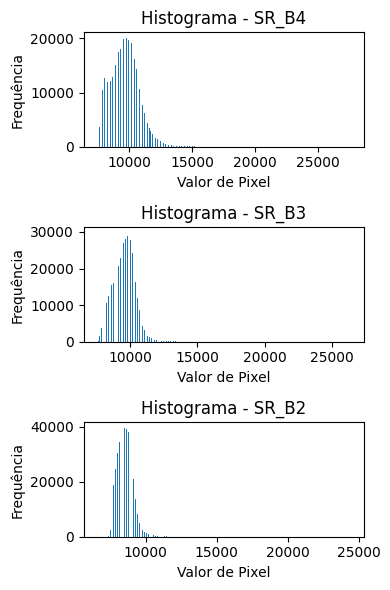

In [9]:
import matplotlib.pyplot as plt

def get_histogram(image, band_name):
    histogram = image.select(band_name).reduceRegion(
        reducer=ee.Reducer.histogram(),
        geometry=area,
        scale=30,
        maxPixels=1e9
    ).get(band_name).getInfo()
    return histogram

# Calcular histogramas das bandas originais
bands = ['SR_B4', 'SR_B3', 'SR_B2']
histograms = {band: get_histogram(collection, band) for band in bands}

# Plotar histogramas originais
fig, axs = plt.subplots(3, 1, figsize=(4, 6))

for i, band in enumerate(bands):
    axs[i].bar(histograms[band]['bucketMeans'], histograms[band]['histogram'], width=50)
    axs[i].set_title(f'Histograma - {band}')
    axs[i].set_xlabel('Valor de Pixel')
    axs[i].set_ylabel('Frequ√™ncia')

plt.tight_layout()
plt.show()

#### Aplicar corre√ß√£o de histograma

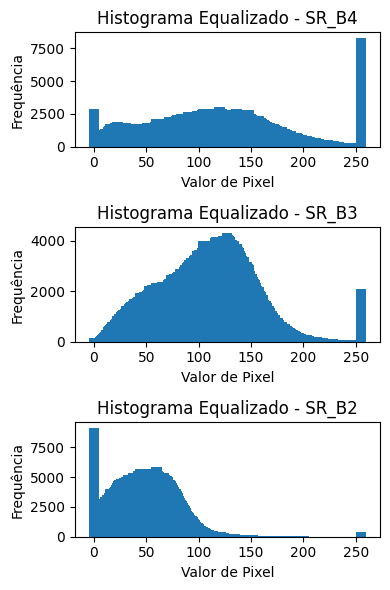

In [10]:
# Calcular os valores percentis
percentiles = collection.reduceRegion(
    reducer=ee.Reducer.percentile([2, 98]),
    geometry=area,
    scale=30,
    maxPixels=1e9
).getInfo()

# Extrair os valores
min_values = [percentiles[f"SR_B{band}_p2"] for band in [4, 3, 2]]
max_values = [percentiles[f"SR_B{band}_p98"] for band in [4, 3, 2]]

# Fun√ß√£o para aplicar corre√ß√£o de histograma
def histogram_equalization(image, bands):
    equalized = image.select(bands).unitScale(min(min_values), max(max_values)).multiply(255).toByte()
    return equalized

# Aplicar corre√ß√£o de histograma √† imagem
equalized_image = histogram_equalization(collection, ['SR_B4', 'SR_B3', 'SR_B2'])

# Calcular histogramas das bandas corrigidas
equalized_histograms = {band: get_histogram(equalized_image, band) for band in bands}

# Plotar histogramas das bandas corrigidas
fig, axs = plt.subplots(3, 1, figsize=(4, 6))

for i, band in enumerate(bands):
    axs[i].bar(equalized_histograms[band]['bucketMeans'], equalized_histograms[band]['histogram'], width=10)
    axs[i].set_title(f'Histograma Equalizado - {band}')
    axs[i].set_xlabel('Valor de Pixel')
    axs[i].set_ylabel('Frequ√™ncia')

plt.tight_layout()
plt.show()

In [11]:
# Plotar
Map = geemap.Map(center=ponto.coordinates().getInfo()[::-1], zoom=12)  # Inverta a ordem das coordenadas para o par√¢metro center
Map.addLayer(equalized_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'LANDSAT/LC08/C02/T1_L2 Equalized')
Map.addLayer(area, {}, 'Regi√£o de Interesse')
Map

Map(center=[-22.66, -45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI‚Ä¶

## 6. √Årea final - visualizar e salvar dado



In [12]:
# Plotar a imagem no mapa
Map.addLayer(equalized_image.clip(area), {'bands': ['SR_B4', 'SR_B3', 'SR_B2']}, 'LANDSAT 8 - Imagem equalizada')
#Map.addLayer(area, {}, 'Regi√£o de Interesse')
Map

Map(center=[-22.66, -45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI‚Ä¶

In [13]:
# Converter as bandas para o mesmo tipo de dados (UInt16)
equalized_image = equalized_image.toUint16()

# Exportar a imagem composta para o Google Drive
imagem_exportada = equalized_image.clip(area)

tarefa = ee.batch.Export.image.toDrive(
    image=imagem_exportada,
    description='CachPta_Landsat8_B4B3B2',
    folder='SensoriamentoGEE',  # Local onde a imagem ser√° salva
    fileNamePrefix='Landsat8',
    region=area.getInfo()['coordinates'],
    scale=30,
    crs='EPSG:4326',
    maxPixels=1e13
)
# maxPixels no GEE √© usado para definir o n√∫mero m√°ximo de pixels de uma imagem
# exportada. O GEE permite at√© 1 bilh√£o de pixels (1e9 pixels) em 1 exporta√ß√£o.

tarefa.start()
print("Exportando para o Google Drive..")


Exportando para o Google Drive..


In [15]:
# Verifique o status das tarefas de exporta√ß√£o
tasks = ee.batch.Task.list()
for task in tasks:
    print(task)

<Task SWXSQBDROY5BJEINVTYF5VJZ EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task UXD25ADALZ3SCWOG34MRRYB6 EXPORT_IMAGE: CachPta_InfravermelhoVegetacao_V2 (COMPLETED)>
<Task UUQU4VRHJXMPFBTSZP52RRVV EXPORT_IMAGE: CachPta_InfravermelhoVegetacao (COMPLETED)>
<Task AACJCL2F772DMAF2Z2PI2JSB EXPORT_IMAGE: CachPta_InfravermelhoVegetacao (COMPLETED)>
<Task Q3J5BRKL2RHTNGNI7HULBAO7 EXPORT_IMAGE: Corrected_Image_SR_B5_SR_B6_SR_B2 (COMPLETED)>
<Task D2URZGHDY4V7JVLY74SR3QMD EXPORT_IMAGE: Corrected_Image_SR_B5_SR_B4_SR_B3 (COMPLETED)>
<Task XPRCVFR7Y7KQXJTVVPDABKHX EXPORT_IMAGE: Corrected_Image_SR_B4_SR_B3_SR_B2 (COMPLETED)>
<Task PPB6JH3KSSBTVSFW3QYWS7UI EXPORT_IMAGE: CachPta_2_Landsat8_B4B3B2 (COMPLETED)>
<Task SSLNEGPJ6RABO4Z5L54VYXCH EXPORT_IMAGE: CachPta_2_Landsat8_B4B3B2 (COMPLETED)>
<Task GJPZ7MCLYLMLGSSNBHZ5A7MR EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task D32RSKBGFALRP24DNUEQSZZP EXPORT_IMAGE: CachPta_Landsat8_B4B3B2 (COMPLETED)>
<Task HEU66FDD7SEP5M6GE5YQCNMC EXPORT_IM